# Exercise 1

### Data-Driven Demand Learning and Dynamic Pricing Strategies in Competitive Markets
https://hpi.de/plattner/teaching/summer-term-2018/data-driven-demand-learning-and-dynamic-pricing-strategies.html

Homework:
* The time between the merchants' price adjustments are randomly chosen between 0.8 and 1.2
  * **Task:** get familiar with the platform by changing the distribution and examining the effects
* A merchant's chance to sell is also determine by the fixed qualities/ratings assigned
  * **Task:** get familiar with the scoring function and study the effects of various weights that determine the scores
* Customer arrival time are currently created using a uniform distribution
  * **Task:** please change to exponential distribution
* The merchants currently use a randomized pricing strategy
  * **Task:** implement the following strategies
  * Two merchants have fixed pricing strategies at 11 and 13 resp.
  * The remaining merchants use varying two-bound strategies (undercutting by 0.5):
    * #1: with 10% change a random price is used, otherwise lower bound of 4.9 and upper bound of 10
    * #2: lower bound of 3.9, upper bound of 9
    * #3: lower bound of 5.9, upper bound of 12


In [87]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

seed = 17*17
np.random.seed(seed)
random.seed(seed)

In [88]:
K = 5                     # number of players
TT = 100                  # time horizon
M = TT + 100              # number of market reaction events. we create more event than the
                          # horizon since we might end up short of 100 (e.g., avg of uniforms = 0.945)

cc = 1                    # mittlerer Abstand zwischen Kunden arrivals
C = int(TT / cc + 100)    # number of customer events

### Simulation Parameters (wann Kunden kommen und Firmen adjusten)

In [89]:
Dk = np.random.uniform(0.9, 1.1, (M, K))     # time between price adjustments of firm k
tk = Dk                                       # time of adjustments of firm k
tk[0,:] = np.random.uniform(0, 1, K)
for m in range(1, M):
    for k in range(K):
        tk[m, k] = tk[m - 1, k] + Dk[m, k]

AT = tk.ravel()                               # set of price adjustments of all firms before time horizon TT
AT = np.sort(np.unique(np.append(AT[AT<TT], 100)))

NAT = len(AT)                                 # number of adjustment times

# param tm   {i in 0..NAT} := if i=0 or i>NAT then 0 else member(i,AT);  # Zeitpunkt der i-ten Preisanpassung
tm = [0] * (NAT + 1)                          # Zeitpunkt der i-ten Preisanpassung
for i in range(NAT):
    tm[i + 1] = AT[i]
DM = [0] * NAT                                 # time between adjustment events
for i in range(NAT):
    DM[i] = tm[i+1] - tm[i]

DC = np.random.exponential(size=C) * cc             # waitung time between customer arrivals
tc =[-1] * C                                    # Zeitpunkt des Ankommens des c-ten Kundens
for i in range(1, C):
    tc[i] = tc[i - 1] + DC[i]

# param ZM   {i in 1..NAT} := min{k in 1..K:sum{j in 1..M:tk[j,k]=tm[i]}1 = 1} k; 
ZM = [0] * NAT                                   # firm k die beim i-ten Gesamtadjust adjusted
for i, t in enumerate(tm):
    res = np.where(tk == t)
    if len(res[1]) > 0:
        ZM[i] = res[1][0]

SC = np.zeros(shape=(C, K))                      # paraemter for customer c scoring of firm k
Zq = np.random.uniform(size = C)                 # customer c random scoring weight for quality
# Zq = np.ones((C,), dtype=int)                  # helper for debugging
Zr = np.random.uniform(0, 0.2, size = C)         # customer c random scoring weight for rating

ZC = np.full(C, -1, dtype=int)                      # for decision of customer c

**A few plots**

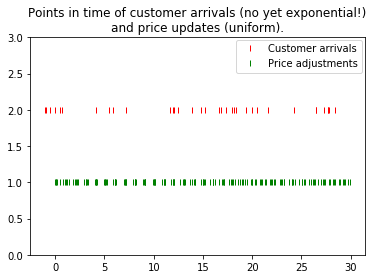

In [90]:
tc_plot = np.array(tc)
tm_plot = np.array(tm)
plot_limit = 30
plt.plot(tc_plot[tc_plot<plot_limit],[2 for _ in tc_plot[tc_plot<plot_limit]],'r|', label='Customer arrivals')
plt.plot(tm_plot[tm_plot<plot_limit],[1 for _ in tm_plot[tm_plot<plot_limit]],'g|', label='Price adjustments')
plt.legend(bbox_to_anchor=(0.99, 0.99), loc=1, borderaxespad=0.)
axes = plt.gca()
plt.title('Points in time of customer arrivals (no yet exponential!)\nand price updates (uniform).')
axes.set_ylim([0.0, 3.0])
plt.show()

### Aktuelle Marktsituation

In [91]:
p = np.round(np.random.uniform(6, 16, size = K))                    # current prices competitors
q = np.round(np.random.uniform(0.5, 5.5, size = K))                 # current quality competitors
r = np.round(np.random.uniform(90, 100, size = K), decimals = 1)    # current prices competitors

# q = np.ones((K,), dtype=int)                                      # helper for debugging

### Hilfsparameter zur Aufzeichnung der Simulation

In [92]:
T = 0                                                         # current time in process

count = 0                                                     # zaehler fuer adjustments of firm 1
F = 0                                                         # betrachtete Firm (obda firm 1)

B = sum([1 if ZM[i] == F else 0 for i in range(NAT - 1)])     # Anzahl der adjustments of firm 1

tb = np.zeros(B + 1)                                          # Zeit der adjustments of firm 1
db = [tb[i] - tb[i-1] for i in range(1, B)]                   # Zeit zwischen adjustments of firm 1
y  = np.zeros(B + 1)                                          # anzahl verkaeufe von firm 1 zwischen adjustments

price  = np.full((1, B + 1), p[F])                            # our Angebotspreis
quali  = np.full((1, B + 1), q[F])                            # our quality
rating = np.full((1, B + 1), r[F])                            # our rating

pcomp = np.zeros(1)                                           # Preise competitor
qcomp = np.zeros(1)                                           # quality competitor
rcomp = np.zeros(1)                                           # rating competitor

G = np.zeros(K)                                               # profit of all firms

G_acc = np.zeros(shape=(NAT, K))                              # accumulated profit of all firms
p_history = np.zeros(shape=(NAT, K))                          # storing prices over time

# Simulation

In [93]:
def undercut(idx, prices, lower_bound, higher_bound):
    new_min_price = np.delete(prices, idx).min() -0.5
    if new_min_price < lower_bound:
        return higher_bound
    else:
        return new_min_price


print("   t               \t   p1    G1         p2   G2            p3   G3")
for i in range(NAT): # gehe M market situations durch, getrennt durch einzelne firm adjustments
    for c in range(C):
        # betrachte ankommende Kunden zwischen firm adjustments
        if not (tm[i] <= tc[c] < tm[i+1]):
            continue

        for k in range(K):
            # Scoring Berechnung für jedes aktuelle Angebot
            SC[c, k] = p[k] + Zq[c] * q[k] + Zr[c] * (100 - r[k])

        if np.min(SC[c,]) < random.randint(5, 16):  # willingness-to-pay des Kunden gross genug?
            scores = list(SC[c,])
            ZC[c] = scores.index(min(scores))

            # profit accumulation for firm ZC[c] that sells to customer c  
            G[ZC[c]] += p[ZC[c]]

    G_acc[i, ] = G

    T += DM[i]
    if T < 100:   # Ausgabe der Simulations-Events bis T=100
        cust_cnt = sum([1 if tm[i] <= tc[c] < tm[i+1] else 0 for c in range(C)])
        did_customer_arrive = ' '
        if cust_cnt > 0:
            did_customer_arrive = '-'
        print("\n {:5.2f} - {:5.2f} {}:\t".format(tm[i], tm[i+1], did_customer_arrive), end='')
        for k in range(K):
            sale_cnt = sum([1 if ((tm[i] <= tc[c] < tm[i+1]) and k == ZC[c]) else 0 for c in range(C)])
            merchant_sold = ' '
            if sale_cnt > 0:
                merchant_sold = str('*' * sale_cnt)
            print("{:>3}{:5.1f} ({:6.2f})  ".format(merchant_sold, p[k], G[k]/T), end='')

                                               
    if T < TT:  # Preisanpassungen der Firmen (je nach dem wer dran ist)
        # stub for the task to implement strategies
        if ZM[i] == 0:
            price = 11
        elif ZM[i] == 1:
            price = 13
        elif ZM[i] == 2:
            if np.random.uniform() < 0.1:
                price = 6 + round(random.random() * 9, 2)
            else:
                price = undercut(2, p, 4.9, 10.0)
        elif ZM[i] == 3:
            price = undercut(3, p, 3.9, 9)
        elif ZM[i] == 4:
            price = undercut(4, p, 5.9, 12.0)

        p[ZM[i]] = price

    p_history[i, ] = p

   t               	   p1    G1         p2   G2            p3   G3

  0.00 -  0.03  :	     9.0 (  0.00)      14.0 (  0.00)      10.0 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.03 -  0.09  :	    11.0 (  0.00)      14.0 (  0.00)      10.0 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.09 -  0.20  :	    11.0 (  0.00)      14.0 (  0.00)       7.5 (  0.00)       8.0 (  0.00)      16.0 (  0.00)  
  0.20 -  0.50 -:	    11.0 (  0.00)      13.0 (  0.00)    *  7.5 ( 15.14)       8.0 (  0.00)      16.0 (  0.00)  
  0.50 -  0.83 -:	    11.0 (  0.00)      13.0 (  0.00)    *  7.5 ( 17.98)       8.0 (  0.00)      16.0 (  0.00)  
  0.83 -  1.02  :	    11.0 (  0.00)      13.0 (  0.00)       7.5 ( 14.76)       7.0 (  0.00)      16.0 (  0.00)  
  1.02 -  1.07  :	    11.0 (  0.00)      13.0 (  0.00)       7.5 ( 13.99)       7.0 (  0.00)       6.5 (  0.00)  
  1.07 -  1.19  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 ( 12.56)       7.0 (  0.00)       6.5 (  0.00)  
  1.19 -  1.42  :	  

 34.65 - 35.07 -:	    11.0 (  0.00)      13.0 (  0.00)       7.5 (  2.77)       8.0 (  0.80)       7.0 (  0.00)  
 35.07 - 35.20  :	    11.0 (  0.00)      13.0 (  0.00)       7.5 (  2.76)       8.0 (  0.80)       7.0 (  0.00)  
 35.20 - 35.33 -:	    11.0 (  0.00)      13.0 (  0.00)       7.5 (  2.75)    *  6.5 (  0.98)       7.0 (  0.00)  
 35.33 - 35.34  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.74)       6.5 (  0.98)       7.0 (  0.00)  
 35.34 - 35.71  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.72)       6.5 (  0.97)      12.0 (  0.00)  
 35.71 - 35.98  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.70)       6.5 (  0.96)      12.0 (  0.00)  
 35.98 - 36.25  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.68)       6.5 (  0.95)      12.0 (  0.00)  
 36.25 - 36.29  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.67)       5.5 (  0.95)      12.0 (  0.00)  
 36.29 - 36.44  :	    11.0 (  0.00)      13.0 (  0.00)      14.1 (  2.66)       5.5 (  0

 60.34 - 60.52  :	    11.0 (  0.00)      13.0 (  0.00)       8.5 (  2.72)       9.5 (  0.92)       9.0 (  0.00)  
 60.52 - 60.93 -:	    11.0 (  0.00)      13.0 (  0.00)    *  8.5 (  2.84)       9.5 (  0.92)       9.0 (  0.00)  
 60.93 - 61.16 -:	    11.0 (  0.00)      13.0 (  0.00)       8.5 (  2.83)       9.5 (  0.92)       9.0 (  0.00)  
 61.16 - 61.32  :	    11.0 (  0.00)      13.0 (  0.00)       8.5 (  2.82)       8.0 (  0.91)       9.0 (  0.00)  
 61.32 - 61.43  :	    11.0 (  0.00)      13.0 (  0.00)       8.5 (  2.82)       8.0 (  0.91)       7.5 (  0.00)  
 61.43 - 61.45  :	    11.0 (  0.00)      13.0 (  0.00)       7.0 (  2.82)       8.0 (  0.91)       7.5 (  0.00)  
 61.45 - 61.99  :	    11.0 (  0.00)      13.0 (  0.00)       7.0 (  2.79)       8.0 (  0.90)       7.5 (  0.00)  
 61.99 - 62.07  :	    11.0 (  0.00)      13.0 (  0.00)       7.0 (  2.79)       8.0 (  0.90)       7.5 (  0.00)  
 62.07 - 62.40  :	    11.0 (  0.00)      13.0 (  0.00)       7.0 (  2.77)       6.5 (  0

 89.88 - 90.33 -:	    11.0 (  0.00)      13.0 (  0.00)       7.5 (  2.82)       6.5 (  1.09)       7.0 (  0.00)  
 90.33 - 90.38  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.82)       6.5 (  1.09)       7.0 (  0.00)  
 90.38 - 90.50  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.81)       6.5 (  1.09)       7.0 (  0.00)  
 90.50 - 90.81  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.80)       6.5 (  1.08)       7.0 (  0.00)  
 90.81 - 90.85  :	    11.0 (  0.00)      13.0 (  0.00)       6.0 (  2.80)       6.5 (  1.08)      12.0 (  0.00)  
 90.85 - 91.36  :	    11.0 (  0.00)      13.0 (  0.00)      11.3 (  2.79)       6.5 (  1.08)      12.0 (  0.00)  
 91.36 - 91.39  :	    11.0 (  0.00)      13.0 (  0.00)      11.3 (  2.79)      10.5 (  1.08)      12.0 (  0.00)  
 91.39 - 91.51  :	    11.0 (  0.00)      13.0 (  0.00)      11.3 (  2.78)      10.5 (  1.08)      12.0 (  0.00)  
 91.51 - 91.80  :	    11.0 (  0.00)      13.0 (  0.00)      11.3 (  2.77)      10.5 (  1

Assigned static qualities for merchants: [4, 2, 1, 5, 5]


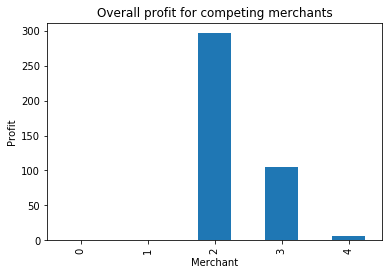

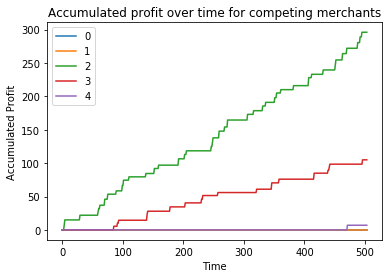

In [94]:
%matplotlib inline
# %matplotlib notebook

plt_profit = pd.DataFrame(G).plot(kind='bar')
plt_profit.set_title("Overall profit for competing merchants")
plt_profit.set_ylabel("Profit")
plt_profit.set_xlabel("Merchant")
plt_profit.legend_.remove()

plt_acc_profit = pd.DataFrame(G_acc).plot()
plt_acc_profit.set_ylabel("Accumulated Profit")
plt_acc_profit.set_xlabel("Time")
plt_acc_profit.set_title("Accumulated profit over time for competing merchants")

print(f'Assigned static qualities for merchants: {list(map(int, q))}')

No handles with labels found to put in legend.


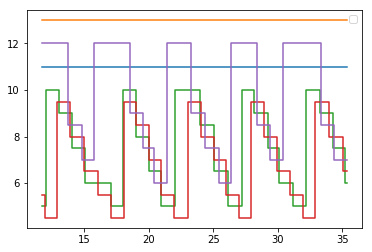

In [95]:
# %matplotlib notebook

for k in range(K):
    plt.step(tm[60:180], p_history[60-1:180-1, k]) # len(tm) == 1 + len(p_hist)
    # selecting 40-180 since it shows nice trajectories
plt.legend()
plt.show()